# Exporting Data to Pardiso and Calculating Band Structure

This tutorial demonstrates how to use the `to_pardiso` method of the `TBSystem` class in DeePTB to export Hamiltonian and overlap matrices, along with structural information, into a format suitable for the Pardiso solver (via a Julia script).

## Objectives
1. Initialize a `TBSystem` with a structure and a trained model.
2. Export the system data using `to_pardiso`.
3. Setup the Julia environment and install necessary packages.
4. Run the external Julia script to calculate the band structure using the exported data.


## 1. Setup Paths

We need to define the paths to our model checkpoint (`.pth`) and the atomic structure file (`.vasp`)., and the Julia script.

In [ ]:
import os
import shutil
import torch
import numpy as np
import subprocess
from pathlib import Path
import sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
from dptb.postprocess.unified.system import TBSystem

root_dir = os.path.abspath("../To_pardiso") 
model_path = os.path.join(root_dir,  "nnsk.iter_ovp0.000.pth")
struct_path = os.path.join(root_dir, "min.vasp")
output_dir = os.path.join(root_dir, "output")



## 2. Initialize TBSystem

We create an instance of `TBSystem`, which loads the atomic structure and the Hamiltonian calculator.

In [6]:
# Initialize the TBSystem
tbsys = TBSystem(data=struct_path, calculator=model_path)
print("TBSystem initialized successfully.")
print(f"System Info: {tbsys.atoms}")

TBSystem initialized successfully.
System Info: Atoms(symbols='C84', pbc=True, cell=[93.478815071, 28.220313831, 4.26])


## 3. Export Data to Pardiso Format

The `tbsys.to_pardiso` method generates several files required by the Julia script:
- `atomic_numbers.dat`: Atomic numbers of the system.
- `positions.dat`: Atomic positions.
- `cell.dat`: Lattice vectors.
- `basis.dat`: Basis set information.
- `predicted_hamiltonians.h5`: The Hamiltonian matrices.
- `predicted_overlaps.h5`: The overlap matrices (if applicable).

In [7]:
# Clean up previous output if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

tbsys.to_pardiso(output_dir=output_dir)

print(f"Data exported to {output_dir}")
print("Generated files:")
for f in sorted(os.listdir(output_dir)):
    print(f" - {f}")

Data exported to /home/vasp/deeptb_fork/local_dptb/DeePTB/examples/To_pardiso/output
Generated files:
 - atomic_numbers.dat
 - basis.dat
 - cell.dat
 - positions.dat
 - predicted_hamiltonians.h5
 - predicted_overlaps.h5


## 4. Setup Julia Environment

Before running the script, we need to ensure that Julia is installed and the required packages are available.

### 4.1 Install Julia

If you haven't installed Julia yet, please follow these steps:

1.  **Download:** Visit [https://julialang.org/downloads/](https://julialang.org/downloads/) and download the version appropriate for your OS (Linux x86_64).
2.  **Extract:** Extract the downloaded tarball, for example:
    ```bash
    tar -xvzf julia-1.9.3-linux-x86_64.tar.gz
    ```
3.  **Add to PATH:** Add the `bin` directory to your system PATH so you can run `julia` from anywhere.
    ```bash
    export PATH="$PATH:/path/to/julia-1.x.x/bin"
    ```

Verify installation by running the cell below:

In [8]:
import subprocess

try:
    # Check Julia version
    result = subprocess.run(["julia", "--version"], capture_output=True, text=True, check=True)
    print(f"Julia is installed: {result.stdout.strip()}")
except (FileNotFoundError, subprocess.CalledProcessError):
    print("Error: 'julia' executable not found. Please install Julia and add it to your PATH.")
    raise RuntimeError("Julia is required for the next steps.")

Julia is installed: julia version 1.6.6


### 4.2 Install Required Packages

The `sparse_calc_npy_print.jl` script requires specific Julia packages. Run the commands below to install them.

**Required External Packages:**
- `JSON`
- `HDF5`
- `ArgParse`
- `Pardiso`
- `Arpack`
- `LinearMaps`
- `JLD`
- `FileIO`

*(Standard library packages like `DelimitedFiles`, `LinearAlgebra`, `SparseArrays`, `Dates`, `Printf` are pre-installed)*

**Installation:**

You can install these by running this command in your terminal:
```bash
julia -e 'using Pkg; Pkg.add(["JSON", "HDF5", "ArgParse", "Pardiso", "Arpack", "LinearMaps", "JLD", "FileIO"])'
```

Or run the following Python cell to execute the installation command for you:

## 5. Run Julia Script

Now that the environment is set up, we use the exported data to calculate the band structure. We need a configuration file (`band.json`) which defines the calculation parameters (e.g., K-path).

In [10]:
# Path to the configuration file
config_path = os.path.join(root_dir, "band.json")

# Define where Julia should save the results
julia_out_dir = os.path.join(output_dir, "julia_results")
if not os.path.exists(julia_out_dir):
    os.makedirs(julia_out_dir)

parent_path = os.path.dirname(os.path.dirname(os.getcwd()))
julia_script = os.path.join(parent_path, "dptb/postprocess/julia/sparse_calc_npy_print.jl")

# Construct the command
cmd = [
    "julia",
    julia_script,
    "--input_dir", output_dir,
    "--output_dir", julia_out_dir,
    "--config", config_path
]

print(f"Running Julia command: {' '.join(cmd)}")
print("This may take a moment...")

try:
    # Run the script
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    print("Julia Execution Successful!")
except subprocess.CalledProcessError as e:
    print("Julia script failed with error:")
    print(e.stdout)
    print(e.stderr)

Running Julia command: julia /home/vasp/deeptb_fork/local_dptb/DeePTB/dptb/postprocess/julia/sparse_calc_npy_print.jl --input_dir /home/vasp/deeptb_fork/local_dptb/DeePTB/examples/To_pardiso/output --output_dir /home/vasp/deeptb_fork/local_dptb/DeePTB/examples/To_pardiso/output/julia_results --config /home/vasp/deeptb_fork/local_dptb/DeePTB/examples/To_pardiso/band.json
This may take a moment...
Julia Execution Successful!


## 6. View Results

The Julia script produces a `bandstructure.npy` file. We can load this file to verify the output.

In [11]:
expected_npy = os.path.join(julia_out_dir, "bandstructure.npy")
data = np.load(expected_npy, allow_pickle=True).item()
print("Successfully loaded bandstructure.npy")
print(f"Data keys: {list(data.keys())}")
if 'eigenvalues' in data:
    evals = data['eigenvalues']
    print(f"Eigenvalues shape: {evals.shape}")


Successfully loaded bandstructure.npy
Data keys: ['eigenvalues', 'xlist', 'labels', 'E_fermi', 'output_path', 'high_sym_kpoints', 'klist']
Eigenvalues shape: (101, 30)


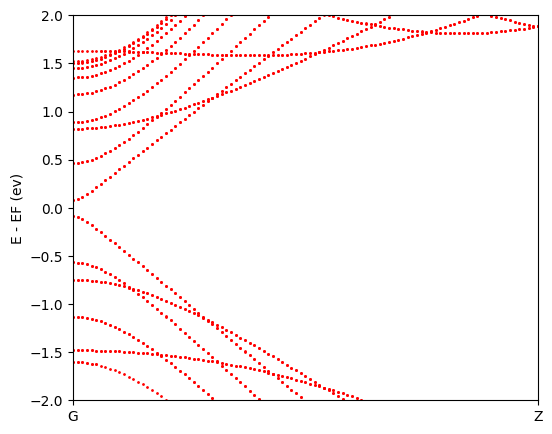

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))

x = data["xlist"]
evals = data["eigenvalues"] - data["E_fermi"]
for i in range(evals.shape[1]):
    plt.scatter(x, evals[:, i], s=1, c='r')
plt.xticks(data["high_sym_kpoints"], data["labels"])
plt.xlim(0,data["xlist"][-1])
plt.ylim(-2,2)
plt.ylabel('E - EF (ev)')
plt.show()